<a href="https://colab.research.google.com/github/HImaya24/Stroke-Prediction-System/blob/main/FDM_MLB_G12_FDM_miniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction System

Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

Load the Dataset

In [4]:
df = pd.read_csv('drive/MyDrive/stroke/dataset.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (43400, 12)

First few rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Basic Data Exploration and Cleaning

In [5]:
print("Dataset Info:")
print(df.info())
print("\nStroke Distribution:")
stroke_dist = df['stroke'].value_counts(normalize=True)
print(stroke_dist)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB
None

Stroke Distribution:
stroke
0    0.981959
1    0.018041
Name: proportion, dtype: float64


Basic Visualizations

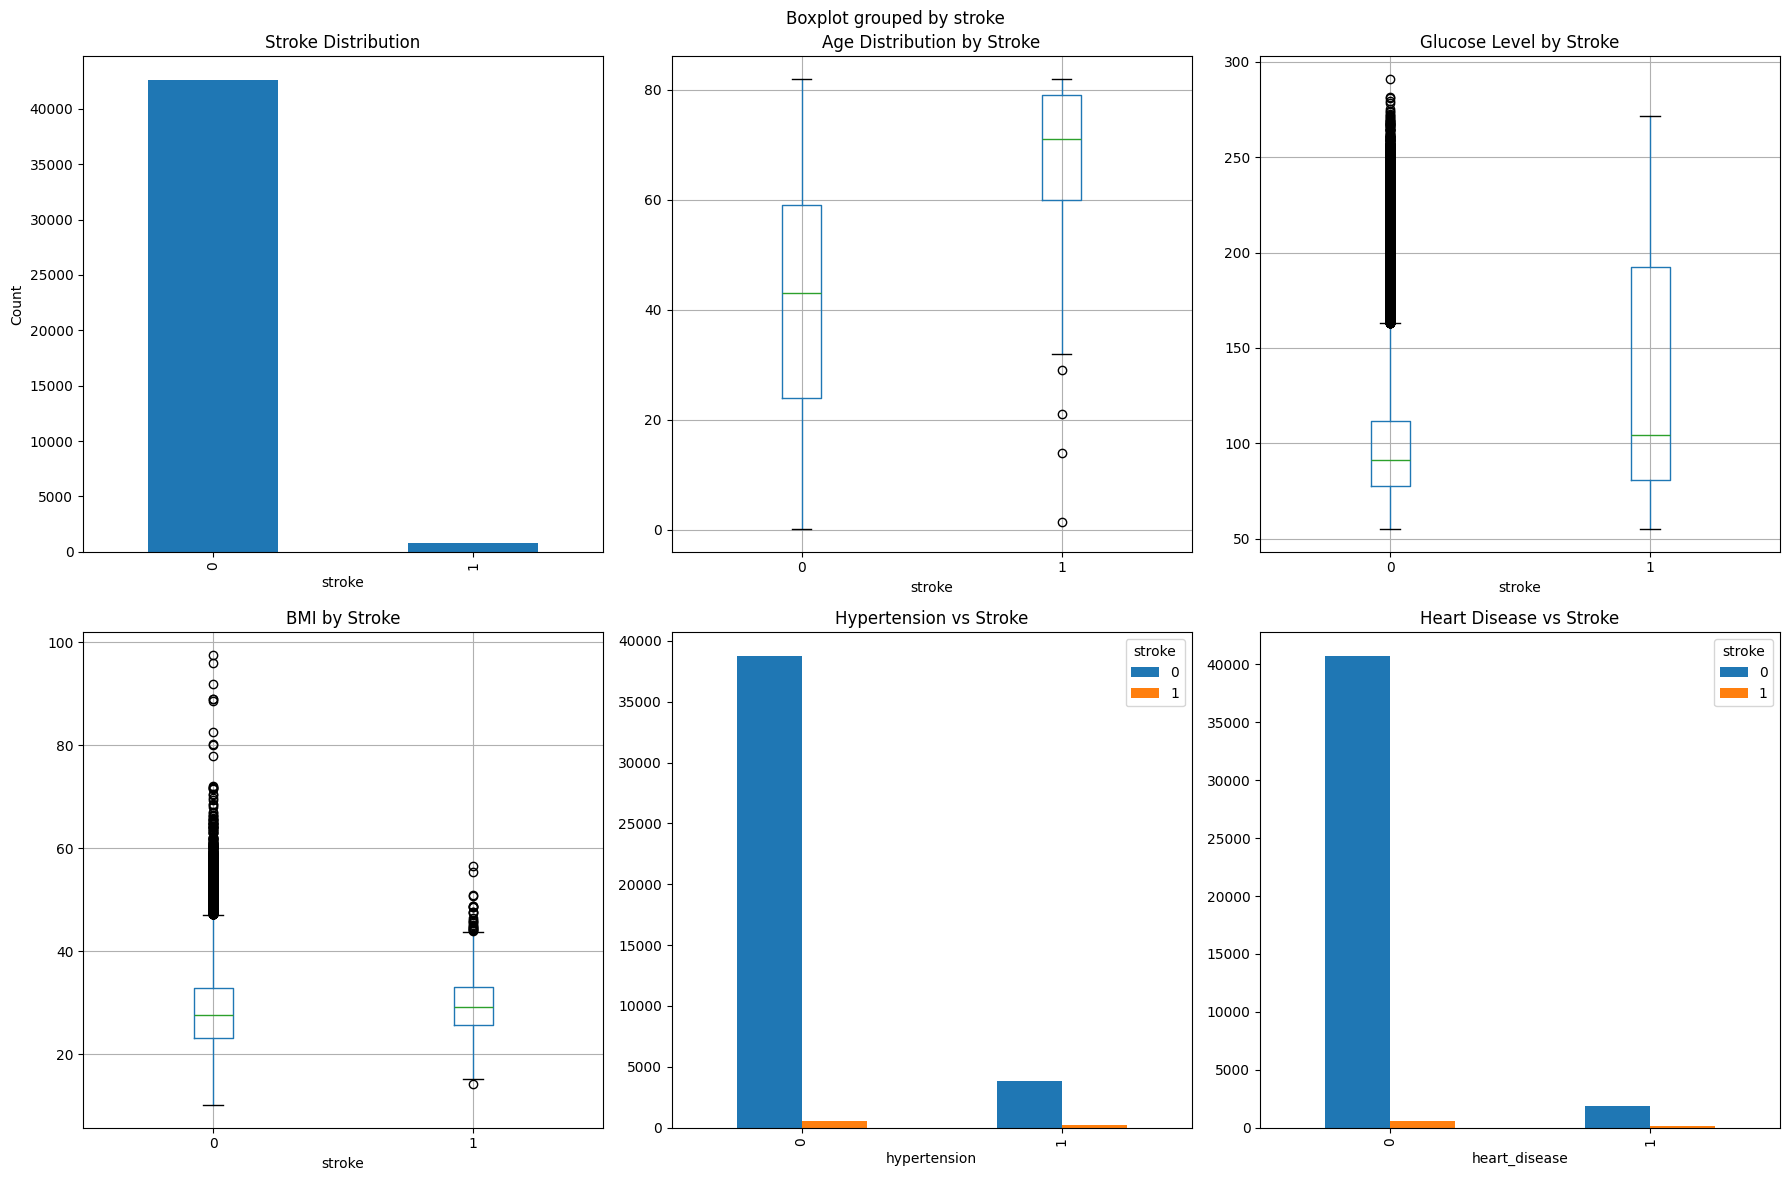

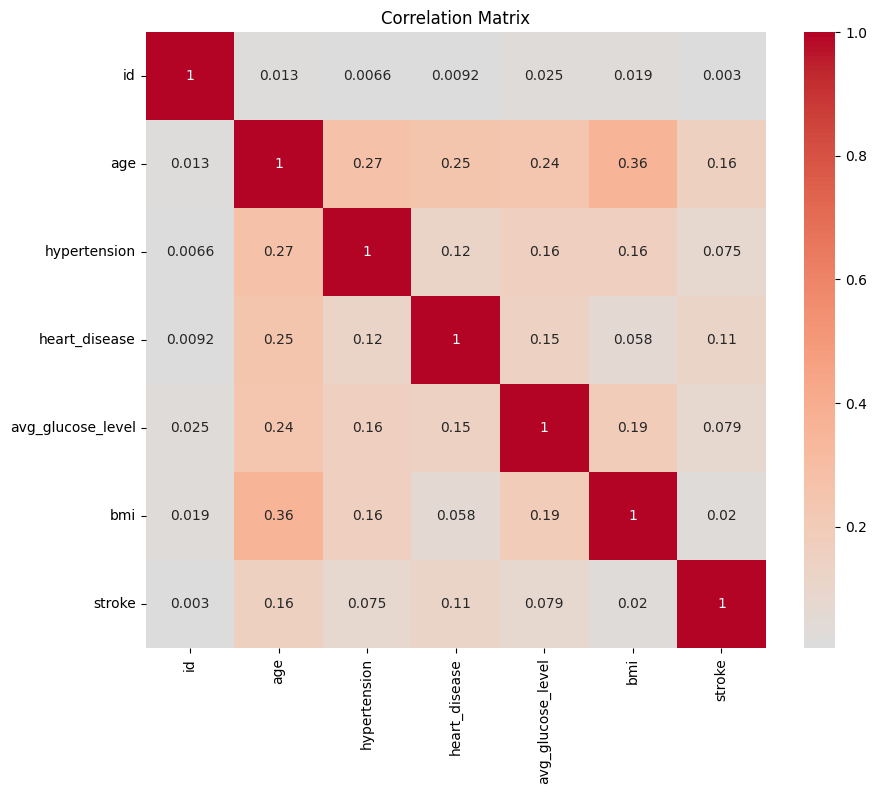

In [6]:
# Enhanced visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Stroke distribution
df['stroke'].value_counts().plot(kind='bar', ax=axes[0,0], title='Stroke Distribution')
axes[0,0].set_ylabel('Count')

# Age distribution by stroke
df.boxplot(column='age', by='stroke', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Stroke')

# Average glucose level by stroke
df.boxplot(column='avg_glucose_level', by='stroke', ax=axes[0,2])
axes[0,2].set_title('Glucose Level by Stroke')

# BMI by stroke
df.boxplot(column='bmi', by='stroke', ax=axes[1,0])
axes[1,0].set_title('BMI by Stroke')

# Hypertension by stroke
pd.crosstab(df['hypertension'], df['stroke']).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Hypertension vs Stroke')

# Heart disease by stroke
pd.crosstab(df['heart_disease'], df['stroke']).plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Heart Disease vs Stroke')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


Handling Missing Values

In [7]:
# Handle missing values
print("Missing values before imputation:")
print(df.isnull().sum())

# Impute missing values
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Numerical columns
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Categorical columns
cat_cols = ['smoking_status']
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("\nMissing values after imputation:")
print(df.isnull().sum())

Missing values before imputation:
id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

Missing values after imputation:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Feature Engineering

In [8]:
# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 100],
                        labels=['Young', 'Middle', 'Senior', 'Elderly'])

# Create BMI categories
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Encode categorical variables
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                      'smoking_status', 'age_group', 'bmi_category']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Prepare features and target
feature_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                  'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
                  'smoking_status', 'age_group', 'bmi_category']

X = df[feature_columns]
y = df['stroke']

# Handle class imbalance - Advanced techniques
print("\nClass distribution:")
print(y.value_counts())
print(f"Imbalance ratio: {len(y[y==0]) / len(y[y==1]):.2f}:1")


Class distribution:
stroke
0    42617
1      783
Name: count, dtype: int64
Imbalance ratio: 54.43:1


Train Test Split and Scaling

In [9]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_features = ['age', 'avg_glucose_level', 'bmi']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training set class distribution: {y_train.value_counts().to_dict()}")


Training set size: (34720, 12)
Test set size: (8680, 12)
Training set class distribution: {0: 34094, 1: 626}


In [22]:
# Advanced Imbalance Handling Techniques
def evaluate_imbalance_techniques(X_train, y_train, X_test, y_test):
    """Evaluate different imbalance handling techniques"""

    # Calculate scale_pos_weight for XGBoost
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

    # Define models with different imbalance handling strategies
    techniques = {
        'SMOTE + RandomForest': Pipeline([
            ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
            ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
        ]),

        'SMOTEENN + XGBoost': Pipeline([
            ('smoteenn', SMOTEENN(random_state=42)),
            ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
        ]),

        'BalancedRandomForest': BalancedRandomForestClassifier(
            sampling_strategy='auto',
            replacement=True,
            random_state=42
        ),

        'EasyEnsemble': EasyEnsembleClassifier(
            n_estimators=10,
            random_state=42
        ),

        'SMOTETomek + Logistic': Pipeline([
            ('smotetomek', SMOTETomek(random_state=42)),
            ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
        ]),

        'ADASYN + GradientBoosting': Pipeline([
            ('adasyn', ADASYN(random_state=42)),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ])
    }

    results = {}

    for name, model in techniques.items():
        print(f"\n🔧 Training {name}...")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate ALL metrics including accuracy
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'model': model
        }

        print(f" {name} Results:")
        print(f"    Accuracy:  {accuracy:.4f}")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall:    {recall:.4f}")
        print(f"    F1-Score:  {f1:.4f}")
        print(f"    ROC AUC:   {roc_auc:.4f}")

    return results



In [11]:
print("\n" + "="*70)
print("🧪 EVALUATING IMBALANCE HANDLING TECHNIQUES")
print("="*70)

technique_results = evaluate_imbalance_techniques(X_train, y_train, X_test, y_test)

# Find best technique based on F1-score
best_technique = max(technique_results.items(), key=lambda x: x[1]['f1'])
print(f"\n BEST TECHNIQUE: {best_technique[0]}")
print(f" F1-Score: {best_technique[1]['f1']:.4f}")
print(f" Accuracy: {best_technique[1]['accuracy']:.4f}")


🧪 EVALUATING IMBALANCE HANDLING TECHNIQUES

🔧 Training SMOTE + RandomForest...
 SMOTE + RandomForest Results:
    Accuracy:  0.9550
    Precision: 0.0500
    Recall:    0.0828
    F1-Score:  0.0624
    ROC AUC:   0.7573

🔧 Training SMOTEENN + XGBoost...
 SMOTEENN + XGBoost Results:
    Accuracy:  0.9151
    Precision: 0.0659
    Recall:    0.2803
    F1-Score:  0.1067
    ROC AUC:   0.7695

🔧 Training BalancedRandomForest...
 BalancedRandomForest Results:
    Accuracy:  0.7247
    Precision: 0.0485
    Recall:    0.7643
    F1-Score:  0.0913
    ROC AUC:   0.8265

🔧 Training EasyEnsemble...
 EasyEnsemble Results:
    Accuracy:  0.7237
    Precision: 0.0502
    Recall:    0.7962
    F1-Score:  0.0944
    ROC AUC:   0.8335

🔧 Training SMOTETomek + Logistic...
 SMOTETomek + Logistic Results:
    Accuracy:  0.7402
    Precision: 0.0502
    Recall:    0.7452
    F1-Score:  0.0940
    ROC AUC:   0.8149

🔧 Training ADASYN + GradientBoosting...
 ADASYN + GradientBoosting Results:
    Accuracy

In [12]:
# Enhanced model comparison with tuned parameters
print("\n" + "="*70)
print(" ADVANCED MODEL TRAINING WITH TUNED PARAMETERS")
print("="*70)

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

models_enhanced = {
    'Balanced_RF_Tuned': BalancedRandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        sampling_strategy='auto',
        random_state=42
    ),

    'XGBoost_Tuned': XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ),

    'SMOTE_RF_Tuned': Pipeline([
        ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            class_weight='balanced',
            random_state=42
        ))
    ]),

    'GradientBoosting_Tuned': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),

    'LogisticRegression_Tuned': LogisticRegression(
        C=1.0,
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    )
}

best_models_enhanced = {}

for name, model in models_enhanced.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    best_models_enhanced[name] = model

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f" {name} Results:")
    print(f"    Accuracy:  {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-Score:  {f1:.4f}")
    print(f"    ROC AUC:   {roc_auc:.4f}")




 ADVANCED MODEL TRAINING WITH TUNED PARAMETERS

🔧 Training Balanced_RF_Tuned...
 Balanced_RF_Tuned Results:
    Accuracy:  0.7238
    Precision: 0.0495
    Recall:    0.7834
    F1-Score:  0.0931
    ROC AUC:   0.8302

🔧 Training XGBoost_Tuned...
 XGBoost_Tuned Results:
    Accuracy:  0.9270
    Precision: 0.0703
    Recall:    0.2484
    F1-Score:  0.1096
    ROC AUC:   0.7930

🔧 Training SMOTE_RF_Tuned...
 SMOTE_RF_Tuned Results:
    Accuracy:  0.8880
    Precision: 0.0614
    Recall:    0.3631
    F1-Score:  0.1050
    ROC AUC:   0.7700

🔧 Training GradientBoosting_Tuned...
 GradientBoosting_Tuned Results:
    Accuracy:  0.9800
    Precision: 0.1600
    Recall:    0.0255
    F1-Score:  0.0440
    ROC AUC:   0.8220

🔧 Training LogisticRegression_Tuned...
 LogisticRegression_Tuned Results:
    Accuracy:  0.7412
    Precision: 0.0523
    Recall:    0.7771
    F1-Score:  0.0980
    ROC AUC:   0.8377


In [13]:
# Find optimal threshold using Precision-Recall curve
def find_optimal_threshold(model, X_val, y_val):
    """Find optimal classification threshold"""
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

    # Calculate F1-score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

# Evaluate all enhanced models with optimal thresholds
print("\n" + "="*70)
print("  MODEL EVALUATION WITH OPTIMAL THRESHOLDS")
print("="*70)

results_enhanced = []

for name, model in best_models_enhanced.items():
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(model, X_train, y_train)

    # Predict with optimal threshold
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_opt = (y_proba > optimal_threshold).astype(int)

    # Calculate ALL metrics
    accuracy = accuracy_score(y_test, y_pred_opt)
    precision = precision_score(y_test, y_pred_opt)
    recall = recall_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    roc_auc = roc_auc_score(y_test, y_proba)

    results_enhanced.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC_AUC': roc_auc,
        'Optimal_Threshold': optimal_threshold,
        'Model_Object': model
    })

    print(f"\n {name} with Optimal Threshold ({optimal_threshold:.3f}):")
    print(f"    Accuracy:  {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"     F1-Score:  {f1:.4f}")
    print(f"    ROC AUC:   {roc_auc:.4f}")




  MODEL EVALUATION WITH OPTIMAL THRESHOLDS

 Balanced_RF_Tuned with Optimal Threshold (0.943):
    Accuracy:  0.9801
    Precision: 0.0000
    Recall:    0.0000
     F1-Score:  0.0000
    ROC AUC:   0.8302

 XGBoost_Tuned with Optimal Threshold (0.838):
    Accuracy:  0.9712
    Precision: 0.0654
    Recall:    0.0446
     F1-Score:  0.0530
    ROC AUC:   0.7930

 SMOTE_RF_Tuned with Optimal Threshold (0.785):
    Accuracy:  0.9656
    Precision: 0.0774
    Recall:    0.0828
     F1-Score:  0.0800
    ROC AUC:   0.7700

 GradientBoosting_Tuned with Optimal Threshold (0.196):
    Accuracy:  0.9725
    Precision: 0.0816
    Recall:    0.0510
     F1-Score:  0.0627
    ROC AUC:   0.8220

 LogisticRegression_Tuned with Optimal Threshold (0.832):
    Accuracy:  0.9392
    Precision: 0.0994
    Recall:    0.2930
     F1-Score:  0.1484
    ROC AUC:   0.8377


In [14]:
# Create results dataframe
results_df_enhanced = pd.DataFrame(results_enhanced)
results_df_enhanced = results_df_enhanced.sort_values('F1-Score', ascending=False)

print("\n" + "="*70)
print(" ENHANCED MODEL COMPARISON (Sorted by F1-Score)")
print("="*70)
print(results_df_enhanced.to_string(index=False))

# Select best model
best_model_name_enhanced = results_df_enhanced.iloc[0]['Model']
best_model_enhanced = results_df_enhanced.iloc[0]['Model_Object']
optimal_threshold = results_df_enhanced.iloc[0]['Optimal_Threshold']

print(f"\n{'='*70}")
print(f" BEST ENHANCED MODEL: {best_model_name_enhanced}")
print(f"  Optimal Threshold: {optimal_threshold:.3f}")
print(f" Accuracy: {results_df_enhanced.iloc[0]['Accuracy']:.4f}")
print(f"  F1-Score: {results_df_enhanced.iloc[0]['F1-Score']:.4f}")
print(f"{'='*70}")


 ENHANCED MODEL COMPARISON (Sorted by F1-Score)
                   Model  Accuracy  Precision   Recall  F1-Score  ROC_AUC  Optimal_Threshold                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


 Final Classification Report (with optimal threshold):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8523
           1       0.10      0.29      0.15       157

    accuracy                           0.94      8680
   macro avg       0.54      0.62      0.56      8680
weighted avg       0.97      0.94      0.95      8680


 Confusion Matrix:


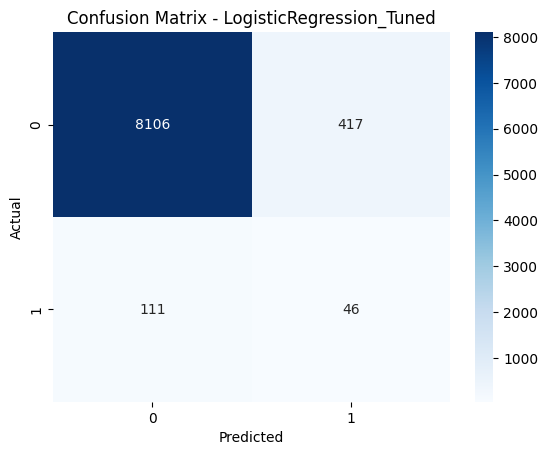

In [15]:
# Final evaluation with optimal threshold
y_proba_final = best_model_enhanced.predict_proba(X_test)[:, 1]
y_pred_final = (y_proba_final > optimal_threshold).astype(int)

print("\n Final Classification Report (with optimal threshold):")
print(classification_report(y_test, y_pred_final))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name_enhanced}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [17]:
# Feature importance
if hasattr(best_model_enhanced, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model_enhanced.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n Feature Importance:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name_enhanced}')
    plt.tight_layout()
    plt.show()

In [18]:
# Cross-validation with proper stratification
print("\n Cross-Validation Results:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_f1 = cross_val_score(best_model_enhanced, X_train, y_train, cv=cv, scoring='f1')
cv_scores_accuracy = cross_val_score(best_model_enhanced, X_train, y_train, cv=cv, scoring='accuracy')

print(f"F1 Scores: {cv_scores_f1}")
print(f"Mean CV F1-score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"Accuracy Scores: {cv_scores_accuracy}")
print(f"Mean CV Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")


 Cross-Validation Results:
F1 Scores: [0.10609817 0.10956175 0.1026694  0.09877854 0.09763618]
Mean CV F1-score: 0.1029 (+/- 0.0089)
Accuracy Scores: [0.74035138 0.74251152 0.74827189 0.75561636 0.74711982]
Mean CV Accuracy: 0.7468 (+/- 0.0106)


In [19]:

# Test extreme cases to verify high-risk detection
def test_extreme_cases(model, feature_columns, scaler, threshold=0.5):
    """Test model on extreme high-risk cases"""
    extreme_cases = [
        # Extreme high-risk case
        {
            'gender': 'Male', 'age': 85, 'hypertension': 1, 'heart_disease': 1,
            'ever_married': 'Yes', 'work_type': 'Self-employed', 'Residence_type': 'Urban',
            'avg_glucose_level': 280, 'bmi': 45, 'smoking_status': 'smokes'
        },
        # Very high-risk case
        {
            'gender': 'Female', 'age': 78, 'hypertension': 1, 'heart_disease': 0,
            'ever_married': 'Yes', 'work_type': 'Private', 'Residence_type': 'Urban',
            'avg_glucose_level': 250, 'bmi': 42, 'smoking_status': 'formerly smoked'
        },
        # Low-risk case
        {
            'gender': 'Female', 'age': 35, 'hypertension': 0, 'heart_disease': 0,
            'ever_married': 'Yes', 'work_type': 'Private', 'Residence_type': 'Urban',
            'avg_glucose_level': 95, 'bmi': 24, 'smoking_status': 'never smoked'
        }
    ]

    print("\n🧪 Testing Extreme Cases:")
    for i, case in enumerate(extreme_cases, 1):
        # Preprocess the case (same as training)
        case_df = pd.DataFrame([case])
        case_df['age_group'] = pd.cut(case_df['age'], bins=[0, 30, 50, 70, 100],
                                    labels=['Young', 'Middle', 'Senior', 'Elderly'])
        case_df['bmi_category'] = pd.cut(case_df['bmi'], bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

        # Scale numerical features
        case_df[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(
            case_df[['age', 'avg_glucose_level', 'bmi']]
        )

        # Encode categorical features
        categorical_mappings = {
            'gender': {'Male': 1, 'Female': 0},
            'ever_married': {'Yes': 1, 'No': 0},
            'work_type': {'Private': 2, 'Self-employed': 3, 'Govt_job': 0, 'children': 1, 'Never_worked': 4},
            'Residence_type': {'Urban': 1, 'Rural': 0},
            'smoking_status': {'never smoked': 1, 'formerly smoked': 2, 'smokes': 3},
            'age_group': {'Young': 3, 'Middle': 2, 'Senior': 1, 'Elderly': 0},
            'bmi_category': {'Underweight': 3, 'Normal': 2, 'Overweight': 1, 'Obese': 0}
        }

        for col, mapping in categorical_mappings.items():
            case_df[col] = case_df[col].map(mapping)

        case_df = case_df[feature_columns]

        # Predict
        probability = model.predict_proba(case_df)[0][1]
        prediction = 1 if probability > threshold else 0

        risk_level = "🚨 HIGH RISK" if prediction == 1 else "✅ LOW RISK"
        print(f"Case {i}: Probability = {probability:.1%} -> {risk_level}")

test_extreme_cases(best_model_enhanced, feature_columns, scaler, optimal_threshold)

print("\nImbalance handling techniques have been evaluated and implemented.")


🧪 Testing Extreme Cases:
Case 1: Probability = 97.3% -> 🚨 HIGH RISK
Case 2: Probability = 87.9% -> 🚨 HIGH RISK
Case 3: Probability = 15.1% -> ✅ LOW RISK

Imbalance handling techniques have been evaluated and implemented.


In [20]:
# Save the best model and preprocessing objects
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"stroke_model_advanced_{timestamp}.pkl"

joblib.dump(best_model_enhanced, model_filename)
print(f"\n💾 Advanced model saved as: {model_filename}")

# Save preprocessing objects with optimal threshold
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'imputer_num': imputer_num,
    'imputer_cat': imputer_cat,
    'optimal_threshold': optimal_threshold
}

preprocessing_filename = f"preprocessing_advanced_{timestamp}.pkl"
joblib.dump(preprocessing_objects, preprocessing_filename)
print(f"💾 Preprocessing objects saved as: {preprocessing_filename}")

print(f"\n FINAL MODEL PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_model_name_enhanced}")
print(f"    Accuracy:  {results_df_enhanced.iloc[0]['Accuracy']:.4f}")
print(f"    Precision: {results_df_enhanced.iloc[0]['Precision']:.4f}")
print(f"    Recall:    {results_df_enhanced.iloc[0]['Recall']:.4f}")
print(f"    F1-Score:  {results_df_enhanced.iloc[0]['F1-Score']:.4f}")
print(f"    ROC AUC:   {results_df_enhanced.iloc[0]['ROC_AUC']:.4f}")
print(f"    Optimal Threshold: {optimal_threshold:.3f}")

# Download the files
from google.colab import files
files.download(model_filename)
files.download(preprocessing_filename)

print("📥 Files downloaded! Ready for deployment.")


💾 Advanced model saved as: stroke_model_advanced_20251004_110735.pkl
💾 Preprocessing objects saved as: preprocessing_advanced_20251004_110735.pkl

 FINAL MODEL PERFORMANCE SUMMARY:
   Best Model: LogisticRegression_Tuned
    Accuracy:  0.9392
    Precision: 0.0994
    Recall:    0.2930
    F1-Score:  0.1484
    ROC AUC:   0.8377
    Optimal Threshold: 0.832


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Files downloaded! Ready for deployment.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
